<a href="https://colab.research.google.com/github/GeomaticsCaminosUPM/geodataset/blob/main/examples/costa_rica_single_image_download.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Costa Rica Google Satellite Image Download

## Download the dataset as a single image

Colab commands for library installation

In [1]:
#Only execute this cell if you are using google colab
!pip install geopandas
!pip install git+https://github.com/GeomaticsCaminosUPM/geodataset.git
!pip install folium matplotlib mapclassify
# After this restart the session

  Cloning https://github.com/GeomaticsCaminosUPM/geodataset.git to /tmp/pip-req-build-8b05n7x6
  Running command git clone --filter=blob:none --quiet https://github.com/GeomaticsCaminosUPM/geodataset.git /tmp/pip-req-build-8b05n7x6
  Resolved https://github.com/GeomaticsCaminosUPM/geodataset.git to commit 50afa80501856adb26dd2cb8847b3e35c547da32
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.1/240.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.7/213.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━

In [1]:
import geopandas as gpd
import shapely
from geodataset import GeoDataset, ImageData, SegmentationData
from geodataset.grid import Grid, tile_size_from_bounds
import geodataset.wms
import geodataset.image
import geodataset.segmentation
import geodataset.raster
import numpy as np

## Data download

For this dataset bounds we will use manually digitalized building footprints in San José (Costa Rica)

In [2]:
!curl -L -o footprints.gpkg https://github.com/GeomaticsCaminosUPM/footprint_attributes/raw/refs/heads/main/examples/footprints.gpkg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  364k  100  364k    0     0   300k      0  0:00:01  0:00:01 --:--:--  300k


In [3]:
footprints_gdf = gpd.read_file('footprints.gpkg')
footprints_gdf = footprints_gdf.explode().reset_index() # Convert multipart to single part geometry

## Dataset Bounds

The dataset bounds will be the bounds (convex hull) of the digitalized area.

In [4]:
dataset_bounds = gpd.GeoSeries(
    shapely.convex_hull(footprints_gdf.union_all()),
    crs=footprints_gdf.crs
)

### Grid

To configure the grid object, you need to specify the desired image resolution and the tile size. Since the grid consists of only one tile (representing the entire dataset bounds), you can use the function `geodataset.grid.tile_size_from_bounds`. By passing the dataset's bounds to this function, you can calculate the width and height of the image in meters.

In [5]:
img_resolution = (0.5, 0.5)  # 50 cm per pixel (width, height)

tile_size = tile_size_from_bounds(dataset_bounds)
tile_size # image (the whole dataset) width and height in meters

(np.float64(820.8806637166999), np.float64(770.6640601356048))

In [6]:
grid = Grid(
    dataset_bounds=dataset_bounds,  # Define the dataset bounds
    resolution=img_resolution,      # Define the image resolution (meters per pixel)
    tile_size=tile_size,                # Define the tile size (meters)
)

# Image provider object

The input data for an image segmentation geodataset consists of **RGB images**.

To prepare the dataset, we will use the latest **Google Satellite image**, available through an **XYZ tile service**.  

### **Common XYZ Tile Service URLs**  

The following urls are direclty accesible as a `dict` at `wms.xyz_service_urls`:
```python
wms.xyz_service_urls = {
    'Google Maps': 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
    'Google Satellite': 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    'Google Terrain': 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
    'Google Satellite Hybrid': 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
    'Esri Satellite': 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    'OpenStreetMap': 'https://tile.openstreetmap.org/{z}/{x}/{y}.png'
}
```

In [7]:
img_url = 'Google Satellite'

We can take a look at the image

In [8]:
basemap = geodataset.wms.xyz_folium_basemap(img_url)
m=dataset_bounds.boundary.explore()
basemap.add_to(m)
m


## Image provider object

The image provider object has the method handles requests and crops the image to the desired bounds and resolution.


In [9]:
img_obj = geodataset.image.XYZ(img_url,dataset_bounds)

Maximum available zoom level is 22 for a max resolution of 0.03832276771737122 m per pixel


## Dataset

- `segmentation` is set to `None` as we only want to donwload the image.
- `hide_outside` is set to `False` as we want to donwload the data even if the image covers some area outside the dataset bounds.

In [10]:
ds = GeoDataset(
    grid=grid,
    image=img_obj,
    segmentation=None,
    hide_outside=False
)

### Downloading Data

To download the image, use the `get_image` method, passing the dataset bounds as a parameter.

#### Notes:
- The `Grid` object did not generate any meaningful tiles since the dataset contains only a single tile, meaning there are no tile IDs.

In [15]:
img,img_bounds = ds.get_image(bounds=dataset_bounds)

## Plotting

Lets plot the image we just downloaded

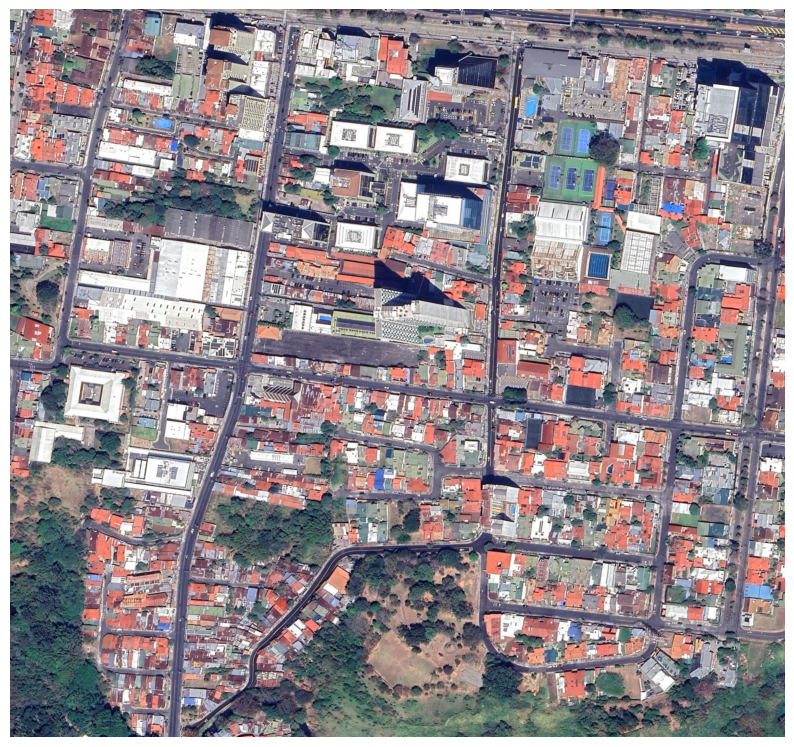

In [16]:
ds.plot(image=img)

## Saving the data

Set the save path and format of image and annotations.

In [17]:
img_path = "/content/image.tif"
img_transposed = np.transpose(img, (2, 0, 1)) # Do not forget to transpose the array to match the PIL image to the format for rasterio
geodataset.raster.save(
    img_path,
    img_transposed,
    bounds=img_bounds,
    driver='GTiff'
  )